**CV2021- week 13**

**CONTENTS**
* [Transfer Learning](https://colab.research.google.com/drive/1u40wZIy0rsvIbZ1iSvxXKh3sijObN2u2#scrollTo=cxVSRNVoTWbl&line=1&uniqifier=1)
* [Variational Autoencoders]()
* [Adversarial learning]()

**H0MEWORK** 

* **1bp** Fit our VAE on the CIFAR-10 images, observe the distribution of the samples corresponding to each class in a 2D space. Change the latent dimension to 3D. Discuss the results. (To get the ability to zoom in/out, change perspective in *pyplot* 3D space, load the predictions locally, and use the GUI provided by *matplotlib* instead of the *colab* non-interactive windows). 
* **1bp** Go through [LSGAN paper](https://arxiv.org/pdf/1611.04076.pdf) and figure out the connection between the loss design and the objective of the learning procedure. What is the model trained for?


**1. Transfer Learning**

In [ ]:
# load the CIFAR 10 data
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def load_cifar10_data():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  return x_train, x_test, y_train, y_test

In [ ]:
X_train, X_test, Y_train, Y_test = load_cifar10_data()

In [ ]:
from sklearn.model_selection import train_test_split

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=13)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
(37500, 32, 32, 3) (37500, 10) (12500, 32, 32, 3) (12500, 10)


In [ ]:
from keras.applications.vgg19 import VGG19

# include top - strips the Classification stage, to allow for transfer learning
base_model = VGG19(include_top=False, weights=None, input_shape=(32,32,3),classes=Y_train.shape[1]) # randomly initialized weights
# for the transfer model we will reuse the weights learnt on imagenet for the feature extraction stage
# as the number of classes is different for the ImageNet challenge, the last layer an not be used
# keras provides access to the feature extraction stage by the 'weights' parameter
transfer_model = VGG19(include_top=False, weights='imagenet',input_shape=(32,32,3),classes=Y_train.shape[1])

In [ ]:
from keras import Sequential
from keras.layers import BatchNormalization, Dense, Dropout, Flatten 


def add_fc_clf_stage(model):
  clf_model = Sequential()
  clf_model.add(model)
  clf_model.add(Flatten())
  clf_model.add(Dense(512,activation=('relu')))
  clf_model.add(BatchNormalization()) 
  clf_model.add(Dropout(0.4))
  clf_model.add(Dense(256,activation=('relu')))
  clf_model.add(BatchNormalization())
  clf_model.add(Dropout(0.2)) 
  clf_model.add(Dense(128,activation=('relu')))
  clf_model.add(BatchNormalization())
  clf_model.add(Dropout(0.1))
  clf_model.add(Dense(10,activation=('softmax')))
  return clf_model

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import History 


# add a keras callback to log values for the metrics
# much more memory safe than the already used TestCallback class
history = History()

train_generator = ImageDataGenerator(rotation_range=30, horizontal_flip=True, zoom_range=.1)
train_generator.fit(X_train)

base_model = add_fc_clf_stage(base_model)
transfer_model = add_fc_clf_stage(transfer_model)

base_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

base_model.fit(train_generator.flow(X_train, Y_train), epochs=15, batch_size=32, validation_data=(X_val, Y_val), callbacks=[history])

Epoch 1/15
1172/1172 [==============================] - 77s 64ms/step - loss: 2.2396 - accuracy: 0.1734 - val_loss: 2.3154 - val_accuracy: 0.1374
Epoch 2/15
1172/1172 [==============================] - 73s 63ms/step - loss: 1.9911 - accuracy: 0.1871 - val_loss: 1.8526 - val_accuracy: 0.2282
Epoch 3/15
1172/1172 [==============================] - 73s 63ms/step - loss: 1.9341 - accuracy: 0.2065 - val_loss: 1.8605 - val_accuracy: 0.2535
Epoch 4/15
1172/1172 [==============================] - 73s 63ms/step - loss: 1.8720 - accuracy: 0.2390 - val_loss: 1.8656 - val_accuracy: 0.2170
Epoch 5/15
1172/1172 [==============================] - 73s 63ms/step - loss: 1.8177 - accuracy: 0.2652 - val_loss: 1.7308 - val_accuracy: 0.3282
Epoch 6/15
1172/1172 [==============================] - 74s 63ms/step - loss: 1.7797 - accuracy: 0.2830 - val_loss: 1.6137 - val_accuracy: 0.3535
Epoch 7/15
1172/1172 [==============================] - 74s 63ms/step - loss: 1.7309 - accuracy: 0.3116 - val_loss: 2.0491 -

In [ ]:
history = History()
transfer_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
transfer_model.fit(train_generator.flow(X_train, Y_train), epochs=15, validation_data=(X_val, Y_val), callbacks=[history])

Epoch 1/15
1172/1172 [==============================] - 125s 105ms/step - loss: 2.1902 - accuracy: 0.1842 - val_loss: 1.9472 - val_accuracy: 0.2122
Epoch 2/15
1172/1172 [==============================] - 75s 64ms/step - loss: 1.9224 - accuracy: 0.2173 - val_loss: 1.7773 - val_accuracy: 0.2869
Epoch 3/15
1172/1172 [==============================] - 74s 63ms/step - loss: 1.8436 - accuracy: 0.2614 - val_loss: 1.6888 - val_accuracy: 0.3090
Epoch 4/15
1172/1172 [==============================] - 74s 64ms/step - loss: 1.7940 - accuracy: 0.2813 - val_loss: 1.7303 - val_accuracy: 0.3210
Epoch 5/15
1172/1172 [==============================] - 79s 68ms/step - loss: 1.7484 - accuracy: 0.3082 - val_loss: 1.7454 - val_accuracy: 0.2890
Epoch 6/15
1172/1172 [==============================] - 75s 64ms/step - loss: 1.7112 - accuracy: 0.3283 - val_loss: 1.7509 - val_accuracy: 0.3043
Epoch 7/15
1172/1172 [==============================] - 74s 64ms/step - loss: 1.6902 - accuracy: 0.3382 - val_loss: 1.6234

**2. Variational Autoencoders**

During this class, we discussed about Autoencoders as models. They are based on learning a representation of the data in a latent space defined by the design choice of our model. The model is built symmetrically, such that the *encoder* part will do the projection of the input sample to the latent space, and the *decoder* will use the latent representation to recover the original input sample. The loss function will be a distance metric between the input sample and the recovered output.


Compared to the *Autoencoder* model, the *Variational Autoencoder* is a model where the *Variational Inference* method is used. Let's say that *x* would be our sample, and we know that there should be a latent variable *z* that generates *x*. According to Bayes rule, we have:

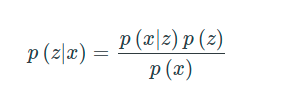

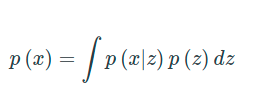

However, this distribution is intractable, since we do not know the properties of the latent space and the reprojection transformation neither. So, we will use variational inference to approximate *p(z|x)* by another *q(z|x)* whose properties we control (e.g. a normal distribution). Introducing this distribution would allow us to sample the latent space by some properties enforced through architectural changes. Using the properties of probability distributions, we can recall that there exists a metric showing how similar two dostributions are, namely the *KL-Divergence*. So, the optimization problem can become:

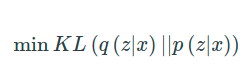

Following the derivation in [the VAE paper](https://arxiv.org/pdf/1907.08956.pdf), you can see that, by introducing the latent *q*, and applying Jensen's inequality, we can see that (where *theta* is the set of parameters for encoding and *phi* is the set of parameters used for decoding): 

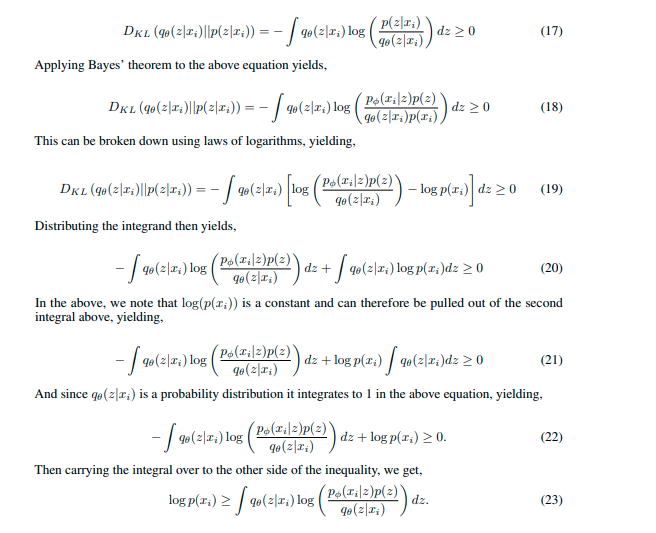

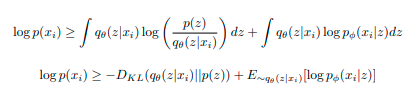

Assuming both *p* and *q* are normally distributed, using the ELBO, the final loss can be derived.
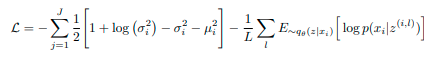

**References**
* [VAE paper](https://arxiv.org/pdf/1312.6114.pdf)
* [Objective derivation](https://arxiv.org/pdf/1907.08956.pdf)
* [VAE in keras](https://keras.io/examples/generative/vae/)

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Layer, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape


class SamplingLayer(Layer):
  """use the mean and the variance as the encoder output to sample the q distr."""
  def call(self, inputs): # stick to the Layer implemnted interface
    mean = inputs[0]
    log_variance = inputs[1]
    bs = tf.shape(mean)[0] # get the batch size
    dim = tf.shape(mean)[1] # get the latent dim
    eps = keras.backend.random_normal(shape=(bs, dim))
    return mean  + eps * tf.exp(0.5 * log_variance) # enforce the normal distr


In [ ]:
latent_dim = 2 # project in 2D space in colab because of pyplot
enc_input = keras.Input(shape=(28, 28, 1)) # MNIST data
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(enc_input)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
latent = Flatten()(x)
projected_latent = Dense(16, activation="relu")(latent) # disentanglement unit
mean = Dense(latent_dim, name="mean")(projected_latent)
log_variance = Dense(latent_dim, name="log_variance")(projected_latent)
latent_sample = SamplingLayer()((mean, log_variance))

In [ ]:
# now we can provide the definition for the encoder to keras to compile the model
encoder = keras.Model(enc_input, [mean, log_variance, latent_sample], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 32)   320         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 3136)         0           conv2d_7[0][0]                   
____________________________________________________________________________________________

In [ ]:
# now, let's build the decoding part
latent_input = keras.Input(shape=(latent_dim, ))
x = Dense(7 * 7 * 64, activation="relu")(latent_input)
x = Reshape((7, 7, 64))(x) # go back to a 2D format
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x_hat = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_input, x_hat, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_55 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [ ]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
          self.total_loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]

  def train_step(self, data):
      with tf.GradientTape() as tape:
        mean, log_variance, latent_sample = self.encoder(data)
        reconstruction = self.decoder(latent_sample)
        # binary clf loss for each pixel in the image
        reconstruction_loss = tf.reduce_mean(
              tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
              )
        )

        kl_loss = -0.5 * (1 + log_variance - tf.square(mean) - tf.exp(log_variance))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
      }


In [ ]:
from keras.datasets import mnist

# we don't need the class labels for now
(x_train, _), (x_test, _) = mnist.load_data()
# use also the testingsplit and normalize the data to (0,1)
# link to the crossentropy loss (binary clf)
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)


11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 9s 11ms/step - loss: 266.0497 - reconstruction_loss: 213.7747 - kl_loss: 2.8764
Epoch 2/30
547/547 [==============================] - 6s 11ms/step - loss: 182.9502 - reconstruction_loss: 171.9838 - kl_loss: 5.6070
Epoch 3/30
547/547 [==============================] - 6s 11ms/step - loss: 168.7303 - reconstruction_loss: 161.4819 - kl_loss: 5.8686
Epoch 4/30
547/547 [==============================] - 6s 11ms/step - loss: 163.8551 - reconstruction_loss: 156.7963 - kl_loss: 6.0552
Epoch 5/30
547/547 [==============================] - 6s 11ms/step - loss: 160.6444 - reconstruction_loss: 153.6741 - kl_loss: 6.2335
Epoch 6/30
547/547 [==============================] - 6s 11ms/step - loss: 158.2362 - reconstruction_loss: 151.6807 - kl_loss: 6.3179
Epoch 7/30
547/547 [==============================] - 6s 11ms/step - loss: 157.3223 - reconstruction_loss: 150.4549 - kl_loss: 6.37

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


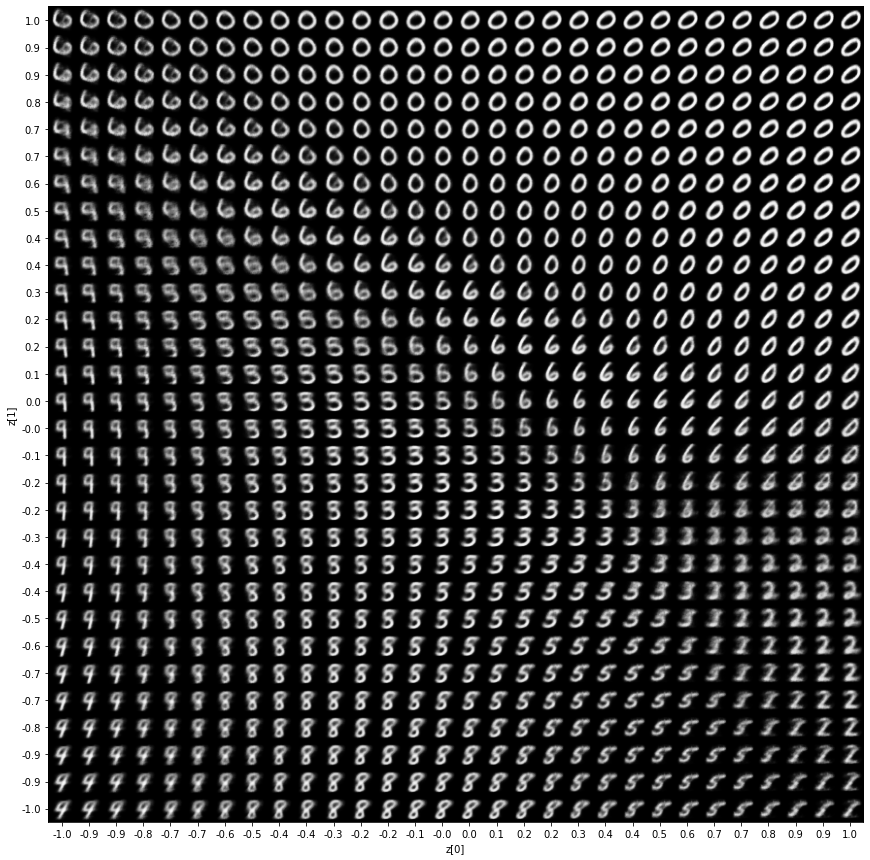

In [ ]:
plot_latent_space(vae)

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

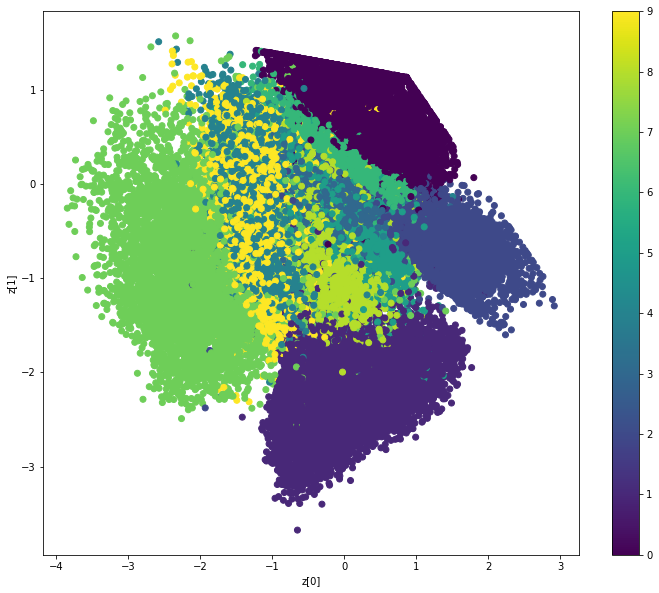

In [ ]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [ ]:
# train for another 50 epochs
vae.fit(mnist_digits, epochs=50, batch_size=128)

Epoch 1/50
547/547 [==============================] - 6s 11ms/step - loss: 149.5451 - reconstruction_loss: 143.2539 - kl_loss: 6.5586
Epoch 2/50
547/547 [==============================] - 6s 11ms/step - loss: 149.3331 - reconstruction_loss: 142.9880 - kl_loss: 6.5637
Epoch 3/50
547/547 [==============================] - 6s 11ms/step - loss: 149.6550 - reconstruction_loss: 142.9581 - kl_loss: 6.5667
Epoch 4/50
547/547 [==============================] - 6s 11ms/step - loss: 149.4101 - reconstruction_loss: 142.9729 - kl_loss: 6.5727
Epoch 5/50
547/547 [==============================] - 6s 11ms/step - loss: 148.9512 - reconstruction_loss: 142.6917 - kl_loss: 6.5914
Epoch 6/50
547/547 [==============================] - 6s 11ms/step - loss: 148.9216 - reconstruction_loss: 142.6628 - kl_loss: 6.5806
Epoch 7/50
547/547 [==============================] - 6s 11ms/step - loss: 149.1191 - reconstruction_loss: 142.6321 - kl_loss: 6.5764
Epoch 8/50
547/547 [==============================] - 6s 11ms/

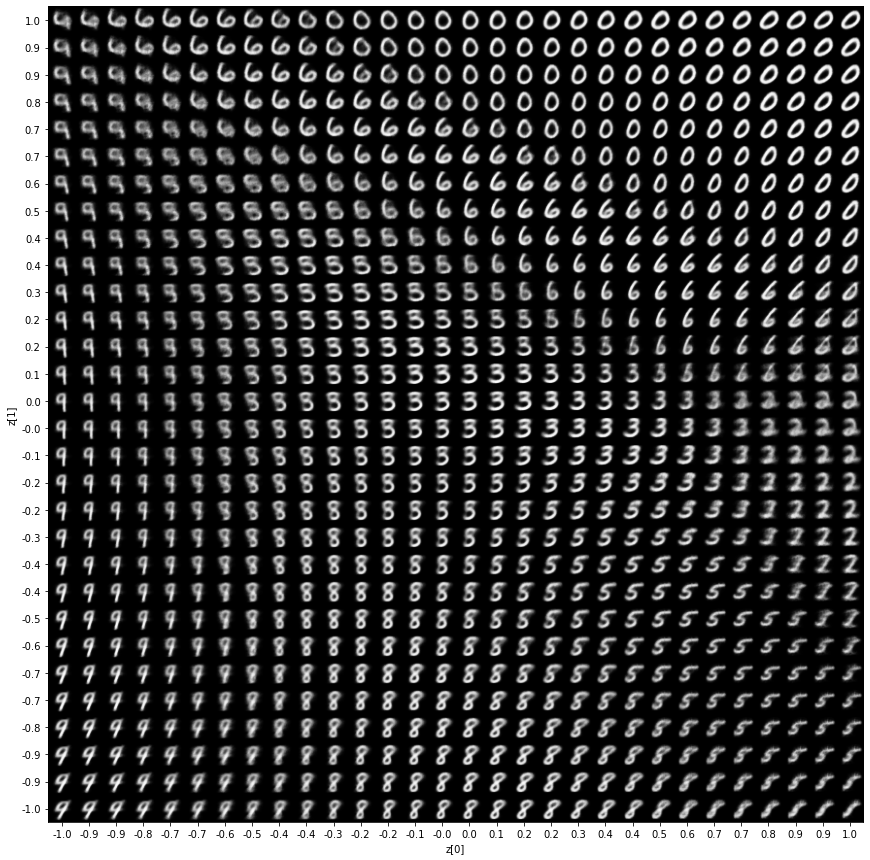

In [ ]:
plot_latent_space(vae)

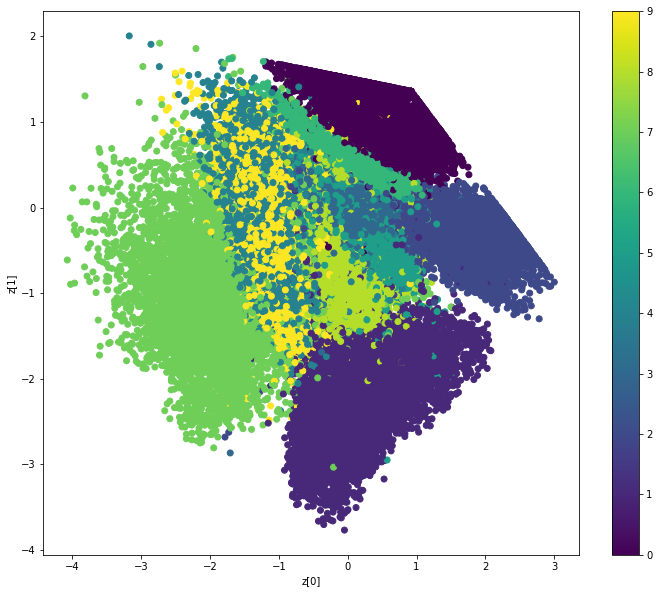

In [ ]:
plot_label_clusters(vae, x_train, y_train)

**3. Adversarial Learning**

The *adversarial learning framework* is based on a joint training procedure of two interacting models. 

The first component of the adversarial framework is the *generator*, that is expected to learn the mapping function between the input and the desired output. The complexity of the generator, and other architectural choices are critical in the learning procedure, as a certain equilibrium has to be reached between the generator and the discriminator, in order to have a successful learning procedure.

The discriminator is the other component in the adversarial learning. It is tasked to evolve against the generator during training, distinguishing between real and fake examples, and pushing the generator to improve in terms of realistical results. 

The complexity of the discriminator is another critical design choice in the adversarial framework, and it depends on the complexity of the results quality assessement performed. A discriminator that is too *weak* or too *powerful* for the generator it is trained against will lead to the failure of the adversarial learning. The most common GAN training issues are described [here](https://developers.google.com/machine-learning/gan/problems).

In this task, we will use the *CelebA* dataset, consisting of a set of images representing faces of various celebrities. In this task, we will assess the ability of a generator trained in the *adversarial framework* to generate realistic-looking faces.

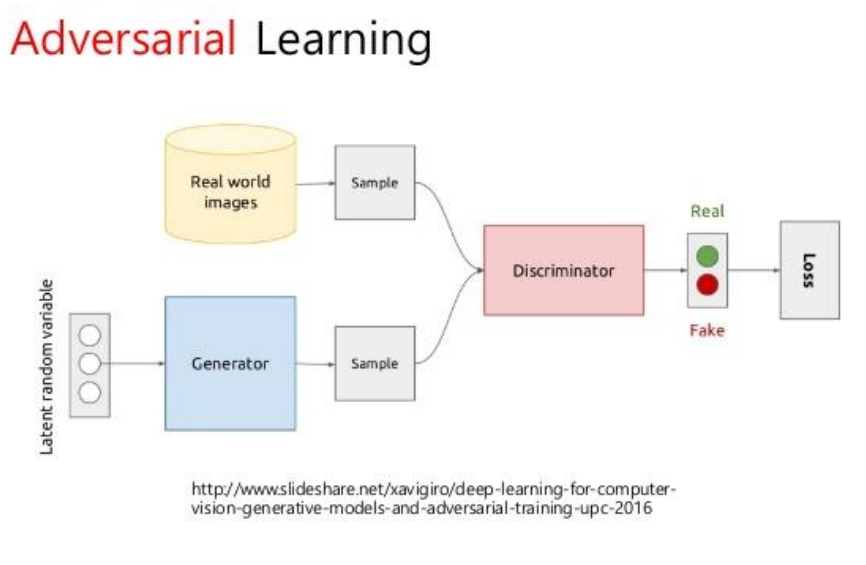

**References**
* [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf)
* [DCGAN in keras](https://keras.io/examples/generative/dcgan_overriding_train_step/#dcgan-to-generate-face-images)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Dropout, Reshape, Dense
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [ ]:
os.makedirs("celeba_gan")


# the dataset can be directly downloaded at
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
  zipobj.extractall("celeba_gan")


In [ ]:
# load all the images and normalize them to [0,1]
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)


Found 202599 files belonging to 1 classes.


In [ ]:
discriminator = keras.Sequential(
  [
    keras.Input(shape=(64, 64, 3)),
    Conv2D(64, kernel_size=4, strides=2, padding="same"),
    LeakyReLU(alpha=0.2),
    Conv2D(128, kernel_size=4, strides=2, padding="same"),
    LeakyReLU(alpha=0.2),
    Conv2D(128, kernel_size=4, strides=2, padding="same"),
    LeakyReLU(alpha=0.2),
    Flatten(),
    Dropout(0.2),
    Dense(1, activation="sigmoid"),
  ],
  name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 32, 32, 64)        3136      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 32, 32, 64)        0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 16, 16, 128)       131200    
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 16, 16, 128)       0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 8, 8, 128)         262272    
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 8, 8, 128)         0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 8192)            

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        Dense(8 * 8 * 128),
        Reshape((8, 8, 128)),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(3, kernel_size=5, padding="same", activation="sigmoid")
        # final normalization using the sigmoid
    ],
    name="generator",
)
generator.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_9 (ModuleWrap (None, 8192)              1056768   
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 8, 8, 128)         0         
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 16, 16, 128)       262272    
_________________________________________________________________
module_wrapper_12 (ModuleWra (None, 16, 16, 128)       0         
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 32, 32, 256)       524544    
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 32, 32, 256)       0         
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 64, 64, 512)       20

In [ ]:
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    # Sample random points in the latent space
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Decode them to fake images
    generated_images = self.generator(random_latent_vectors)

    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )
        

    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    # Train the discriminator
    with tf.GradientTape() as tape:
        predictions = self.discriminator(combined_images)
        d_loss = self.loss_fn(labels, predictions)

    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
    )

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
    
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # Update metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
        
    return {
        "d_loss": self.d_loss_metric.result(),
        "g_loss": self.g_loss_metric.result(),
    }


In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/local_results/generated_img_%03d_%d.png" % (epoch, i))


In [ ]:
import cv2 as cv 



plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200

def plot_gan_results(num_epochs, num_images):
  result_img = np.zeros((64 * num_epochs, 64 * num_images, 3), dtype=np.uint8)
  for i in range(num_epochs):
    for j in range(num_images):
      img = cv.imread("/content/local_results/generated_img_%03d_%d.png" % (i, j))
      result_img[64*i: 64*(i+1), 64*j: 64*(j + 1), :] = img
  
  plt.imshow(result_img)


In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(dataset, epochs=1, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])


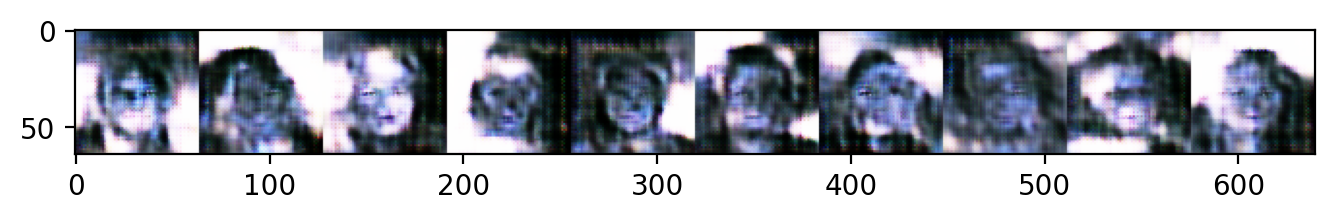

In [ ]:
plot_gan_results(1, 10)

In [ ]:
gan.fit(dataset, epochs=5, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

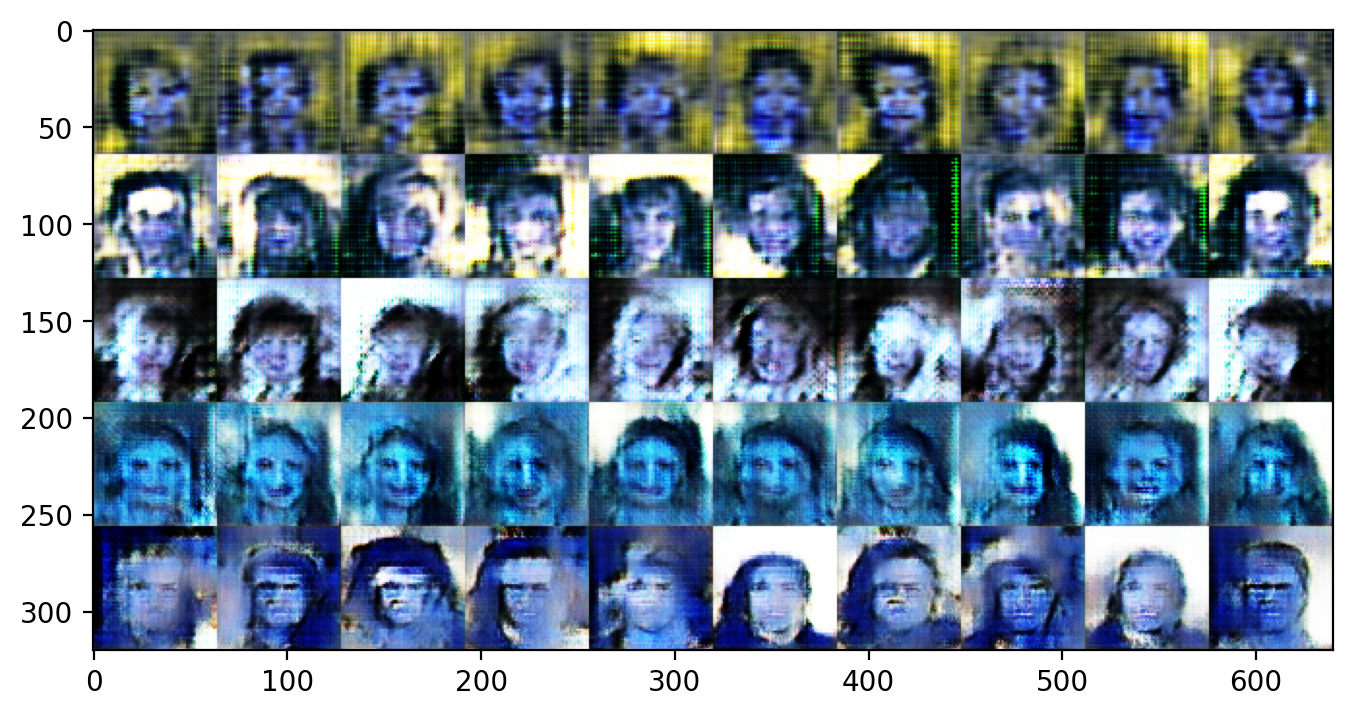

In [ ]:
plot_gan_results(5, 10)